# 1.Required Packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from efficientnet_pytorch import EfficientNet
import numpy as np
import time

import matplotlib.pyplot as plt

# 2.Function Implementation

In [2]:
# plot 4 metrics during training progress
def plot_training_progress(results_path):
    data = torch.load(results_path)
    fig, ax1 = plt.subplots()
    plt.plot(data["train_loss"], 'r', label = 'train_loss')
    plt.plot(data["val_loss"], 'm', label = 'val_loss')
    plt.legend(loc='upper right')
    plt.xlabel('epoch')
    plt.ylabel('loss')

    ax2=ax1.twinx()
    plt.plot(data["train_accuracy"], 'g', label = 'train_accuracy')
    plt.plot(data["val_accuracy"], 'b', label = 'val_accuracy')
    plt.legend(loc='lower right')
    ax2.set_ylabel('accuracy')

    plt.show()

# 3.Model Implementation and Training

## 3.1 VGG16

## 3.2 Inception-V3

### 3.2.1 without Augmentation

In [ ]:
# time recording start
start_time = time.time()

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

# Define transforms for data preprocessing
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize input images to match InceptionV3 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize input images
])

# Load the combined dataset
dataset = ImageFolder('./MO_106/', transform=transform)

# Split the dataset into training and validation sets
train_ratio = 0.8  # 80% for training, 20% for validation
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Training loop
num_epochs = 10
batch_size = 32
lr = 0.001

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize the InceptionV3 model
model = torchvision.models.inception_v3(pretrained=True)
model.aux_logits = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(dataset.classes))

# Move the model to the device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# initialise ndarray to store the loss and accuracy in each epoch (on the training data)
train_loss = np.zeros(num_epochs)
train_accuracy = np.zeros(num_epochs)
val_loss = np.zeros(num_epochs)
val_accuracy = np.zeros(num_epochs)

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss_epoch = 0.0
    correct_predictions_val = 0
    total_predictions_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_epoch += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            correct_predictions_val += (predicted == labels).sum().item()
            total_predictions_val += labels.size(0)

    # Calculate average epoch loss and accuracy
    train_loss[epoch] = running_loss / len(train_dataset)
    train_accuracy[epoch] = correct_predictions / total_predictions
    val_loss[epoch] = val_loss_epoch / len(val_dataset)
    val_accuracy[epoch] = correct_predictions_val / total_predictions_val

    # Print training and validation statistics
    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss[epoch]:.4f}, Train Accuracy: {train_accuracy[epoch]:.4f}, Val Loss: {val_loss[epoch]:.4f}, Val Accuracy: {val_accuracy[epoch]:.4f}')

end_time = time.time()
total_time = end_time - start_time
print(f"Training took {total_time:.2f} seconds.")

model_metrics = {
    "model_state_dict": model.state_dict(),
    "train_loss": train_loss,
    "train_accuracy": train_accuracy,
    "val_loss": val_loss,
    "val_accuracy": val_accuracy,
    'total_time': total_time
}

# Save the model parameters and metrics to a file
ResultPath = "./results/"
results_path = ResultPath + f"inceptionv3_epoch{num_epochs}_lr{lr}_bs{batch_size}.pt"

torch.save(model_metrics, results_path)


c:\ProgramData\Anaconda3\envs\MushroomSafe\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\MushroomSafe\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10: Train Loss: 3.7382, Train Accuracy: 0.1252, Val Loss: 3.2795, Val Accuracy: 0.1842
Epoch 2/10: Train Loss: 2.6137, Train Accuracy: 0.3150, Val Loss: 2.3065, Val Accuracy: 0.3792
Epoch 3/10: Train Loss: 2.0710, Train Accuracy: 0.4336, Val Loss: 2.1183, Val Accuracy: 0.4237
Epoch 4/10: Train Loss: 1.7166, Train Accuracy: 0.5130, Val Loss: 1.8163, Val Accuracy: 0.5149
Epoch 5/10: Train Loss: 1.4589, Train Accuracy: 0.5821, Val Loss: 1.6071, Val Accuracy: 0.5490
Epoch 6/10: Train Loss: 1.2358, Train Accuracy: 0.6340, Val Loss: 1.6483, Val Accuracy: 0.5617
Epoch 7/10: Train Loss: 1.0592, Train Accuracy: 0.6837, Val Loss: 1.5401, Val Accuracy: 0.5947
Epoch 8/10: Train Loss: 0.8958, Train Accuracy: 0.7241, Val Loss: 1.5194, Val Accuracy: 0.6024
Epoch 9/10: Train Loss: 0.7647, Train Accuracy: 0.7630, Val Loss: 1.5728, Val Accuracy: 0.6022
Epoch 10/10: Train Loss: 0.6414, Train Accuracy: 0.8000, Val Loss: 1.7879, Val Accuracy: 0.5725
Training took 3111.97 seconds.


In [ ]:
# plot training progress
plot_training_progress(results_path)

## 3.3 ResNet

## 3.4 MobileNet

## 3.5 EfficientNet

### 3.5.1 EfficientNet B0

#### 3.5.1.1 No Augmentation

In [3]:
# time recording start
start_time = time.time()

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

# Define transforms for data preprocessing
transform = transforms.Compose([
    transforms.Resize((456, 456)),  # Resize input images to match EfficientNet-B5 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize input images
])

# Load the combined dataset
dataset = ImageFolder('./MO_106/', transform=transform)

# Split the dataset into training and validation sets
train_ratio = 0.8  # 80% for training, 20% for validation
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Training loop
num_epochs = 10
batch_size = 40
lr = 0.0001

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize the EfficientNet-B5 model
model = EfficientNet.from_pretrained('efficientnet-b0')

# Replace the classifier with a new one for your specific number of classes
num_classes = len(dataset.classes)
print(num_classes)
model._fc = nn.Linear(model._fc.in_features, num_classes)

# Move the model to the device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# initialise ndarray to store the loss and accuracy in each epoch (on the training data)
train_loss = np.zeros(num_epochs)
train_accuracy = np.zeros(num_epochs)
val_loss = np.zeros(num_epochs)
val_accuracy = np.zeros(num_epochs)

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss_epoch = 0.0
    correct_predictions_val = 0
    total_predictions_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_epoch += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            correct_predictions_val += (predicted == labels).sum().item()
            total_predictions_val += labels.size(0)

    # Calculate average epoch loss and accuracy
    train_loss[epoch] = running_loss / len(train_dataset)
    train_accuracy[epoch] = correct_predictions / total_predictions
    val_loss[epoch] = val_loss_epoch / len(val_dataset)
    val_accuracy[epoch] = correct_predictions_val / total_predictions_val

    # Print training and validation statistics
    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss[epoch]:.4f}, Train Accuracy: {train_accuracy[epoch]:.4f}, Val Loss: {val_loss[epoch]:.4f}, Val Accuracy: {val_accuracy[epoch]:.4f}')

end_time = time.time()
total_time = end_time - start_time
print(f"Training took {total_time:.2f} seconds.")

model_metrics = {
    "model_state_dict": model.state_dict(),
    "train_loss": train_loss,
    "train_accuracy": train_accuracy,
    "val_loss": val_loss,
    "val_accuracy": val_accuracy,
    'total_time': total_time
}

# Save the model parameters and metrics to a file
ResultPath = "./results/"
results_path = ResultPath + f"efficientnetb0_epoch{num_epochs}_lr{lr}_bs{batch_size}.pt"

torch.save(model_metrics, results_path)


Loaded pretrained weights for efficientnet-b0
106
Epoch 1/10: Train Loss: 2.9547, Train Accuracy: 0.3760, Val Loss: 1.5122, Val Accuracy: 0.6235
Epoch 2/10: Train Loss: 1.2809, Train Accuracy: 0.6799, Val Loss: 0.9406, Val Accuracy: 0.7469
Epoch 3/10: Train Loss: 0.8155, Train Accuracy: 0.7886, Val Loss: 0.7159, Val Accuracy: 0.7966
Epoch 4/10: Train Loss: 0.5640, Train Accuracy: 0.8500, Val Loss: 0.6229, Val Accuracy: 0.8201
Epoch 5/10: Train Loss: 0.4055, Train Accuracy: 0.8926, Val Loss: 0.5672, Val Accuracy: 0.8313
Epoch 6/10: Train Loss: 0.3069, Train Accuracy: 0.9206, Val Loss: 0.5644, Val Accuracy: 0.8373
Epoch 7/10: Train Loss: 0.2223, Train Accuracy: 0.9435, Val Loss: 0.5407, Val Accuracy: 0.8443
Epoch 8/10: Train Loss: 0.1752, Train Accuracy: 0.9573, Val Loss: 0.5523, Val Accuracy: 0.8416
Epoch 9/10: Train Loss: 0.1400, Train Accuracy: 0.9646, Val Loss: 0.5572, Val Accuracy: 0.8519
Epoch 10/10: Train Loss: 0.1142, Train Accuracy: 0.9722, Val Loss: 0.5545, Val Accuracy: 0.8498

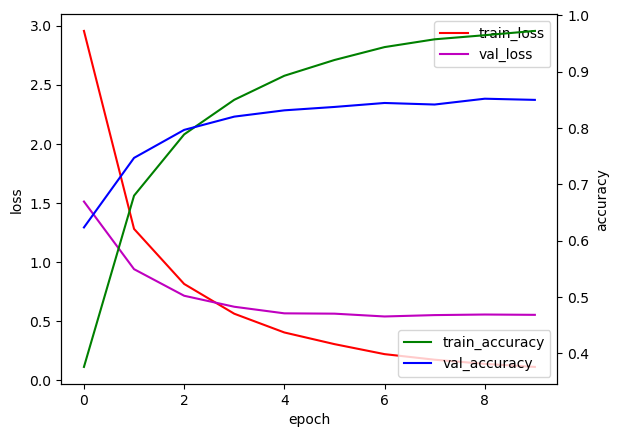

In [4]:
plot_training_progress(results_path)

#### 3.5.1.3 No Augmentation with Feature Pyramids Network

In [5]:
# time recording start
start_time = time.time()

# Set the device to GPU if available, otherwise use CPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# torch.cuda.empty_cache()
device = torch.device("mps")

# Define transforms for data preprocessing
transform = transforms.Compose([
    transforms.Resize((456, 456)),  # Resize input images to match EfficientNet-B5 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize input images
])

# Load the combined dataset
dataset = ImageFolder('./MO_106/', transform=transform)

# Split the dataset into training and validation sets
train_ratio = 0.8  # 80% for training, 20% for validation
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Training loop
num_epochs = 10
batch_size = 15
lr = 0.0001

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Feature Pyramids
class FPN(nn.Module):
    def __init__(self, base_model):
        super(FPN, self).__init__()
        self.base_model = base_model
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.conv = nn.Conv2d(1280, 256, kernel_size=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.base_model.extract_features(x)
        x = self.pool(x)
        x = self.conv(x)
        x = self.relu(x)
        return x


# Initialize the EfficientNet-B5 model
backbone_model = EfficientNet.from_pretrained('efficientnet-b0')
backbone_model.to(device)

# Replace the classifier with a new one for your specific number of classes
num_classes = len(dataset.classes)

# Move the model to the device
fpn_model = FPN(backbone_model)
fpn_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fpn_model.parameters(), lr=lr)

# initialise ndarray to store the loss and accuracy in each epoch (on the training data)
train_loss = np.zeros(num_epochs)
train_accuracy = np.zeros(num_epochs)
val_loss = np.zeros(num_epochs)
val_accuracy = np.zeros(num_epochs)

for epoch in range(num_epochs):
    fpn_model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = fpn_model(images)
        labels = labels.unsqueeze(1)
        loss = criterion(outputs, labels)


        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    # Validation loop
    fpn_model.eval()  # Set the model to evaluation mode
    val_loss_epoch = 0.0
    correct_predictions_val = 0
    total_predictions_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = fpn_model(images)
            labels = labels.unsqueeze(1)
            loss = criterion(outputs, labels)
            val_loss_epoch += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            correct_predictions_val += (predicted == labels).sum().item()
            total_predictions_val += labels.size(0)

    # Calculate average epoch loss and accuracy
    train_loss[epoch] = running_loss / len(train_dataset)
    train_accuracy[epoch] = correct_predictions / total_predictions
    val_loss[epoch] = val_loss_epoch / len(val_dataset)
    val_accuracy[epoch] = correct_predictions_val / total_predictions_val

    # Print training and validation statistics
    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss[epoch]:.4f}, Train Accuracy: {train_accuracy[epoch]:.4f}, Val Loss: {val_loss[epoch]:.4f}, Val Accuracy: {val_accuracy[epoch]:.4f}')

end_time = time.time()
total_time = end_time - start_time
print(f"Training took {total_time:.2f} seconds.")

model_metrics = {
    "model_state_dict": fpn_model.state_dict(),
    "train_loss": train_loss,
    "train_accuracy": train_accuracy,
    "val_loss": val_loss,
    "val_accuracy": val_accuracy,
    'total_time': total_time
}

# Save the model parameters and metrics to a file
ResultPath = "./results/"
results_path = ResultPath + f"efficientnetb0_fpn_epoch{num_epochs}_lr{lr}_bs{batch_size}.pt"

torch.save(model_metrics, results_path)


Loaded pretrained weights for efficientnet-b0


RuntimeError: MPS backend out of memory (MPS allocated: 17.10 GB, other allocations: 914.45 MB, max allowed: 18.13 GB). Tried to allocate 285.56 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

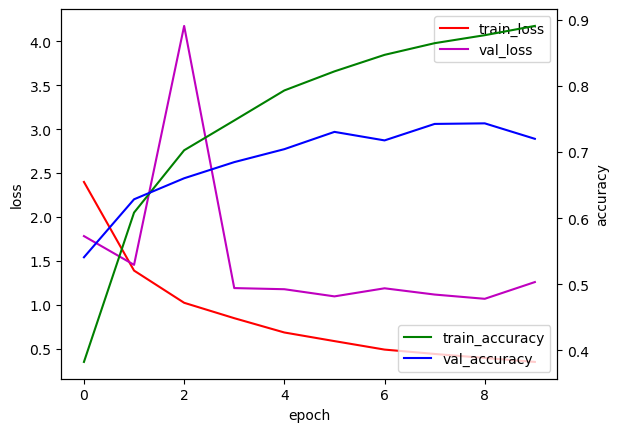

In [ ]:
# plot training progress
plot_training_progress(results_path)

### 3.5.2 EfficientNet B5

#### 3.5.2.1 No Augmentation

In [1]:
# time recording start
start_time = time.time()

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

# Define transforms for data preprocessing
transform = transforms.Compose([
    transforms.Resize((456, 456)),  # Resize input images to match EfficientNet-B5 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize input images
])

# Load the combined dataset
dataset = ImageFolder('./MO_106/', transform=transform)

# Split the dataset into training and validation sets
train_ratio = 0.8  # 80% for training, 20% for validation
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Training loop
num_epochs = 10
batch_size = 10
lr = 0.0001

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize the EfficientNet-B5 model
model = EfficientNet.from_pretrained('efficientnet-b5')

# Replace the classifier with a new one for your specific number of classes
num_classes = len(dataset.classes)
print(num_classes)
model._fc = nn.Linear(model._fc.in_features, num_classes)

# Move the model to the device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# initialise ndarray to store the loss and accuracy in each epoch (on the training data)
train_loss = np.zeros(num_epochs)
train_accuracy = np.zeros(num_epochs)
val_loss = np.zeros(num_epochs)
val_accuracy = np.zeros(num_epochs)

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss_epoch = 0.0
    correct_predictions_val = 0
    total_predictions_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_epoch += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            correct_predictions_val += (predicted == labels).sum().item()
            total_predictions_val += labels.size(0)

    # Calculate average epoch loss and accuracy
    train_loss[epoch] = running_loss / len(train_dataset)
    train_accuracy[epoch] = correct_predictions / total_predictions
    val_loss[epoch] = val_loss_epoch / len(val_dataset)
    val_accuracy[epoch] = correct_predictions_val / total_predictions_val

    # Print training and validation statistics
    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss[epoch]:.4f}, Train Accuracy: {train_accuracy[epoch]:.4f}, Val Loss: {val_loss[epoch]:.4f}, Val Accuracy: {val_accuracy[epoch]:.4f}')

end_time = time.time()
total_time = end_time - start_time
print(f"Training took {total_time:.2f} seconds.")

model_metrics = {
    "model_state_dict": model.state_dict(),
    "train_loss": train_loss,
    "train_accuracy": train_accuracy,
    "val_loss": val_loss,
    "val_accuracy": val_accuracy,
    'total_time': total_time
}

# Save the model parameters and metrics to a file
ResultPath = "./results/"
results_path = ResultPath + f"efficientnetb5_epoch{num_epochs}_lr{lr}_bs{batch_size}.pt"

torch.save(model_metrics, results_path)


Loaded pretrained weights for efficientnet-b5
106
Epoch 1/10: Train Loss: 2.4528, Train Accuracy: 0.3724, Val Loss: 1.7555, Val Accuracy: 0.5308
Epoch 2/10: Train Loss: 1.4218, Train Accuracy: 0.6018, Val Loss: 1.3744, Val Accuracy: 0.6328
Epoch 3/10: Train Loss: 1.0714, Train Accuracy: 0.6896, Val Loss: 1.2637, Val Accuracy: 0.6806
Epoch 4/10: Train Loss: 0.8529, Train Accuracy: 0.7479, Val Loss: 1.1754, Val Accuracy: 0.6876
Epoch 5/10: Train Loss: 0.7091, Train Accuracy: 0.7856, Val Loss: 1.0731, Val Accuracy: 0.7189
Epoch 6/10: Train Loss: 0.5848, Train Accuracy: 0.8189, Val Loss: 1.1896, Val Accuracy: 0.7098
Epoch 7/10: Train Loss: 0.5040, Train Accuracy: 0.8463, Val Loss: 1.0774, Val Accuracy: 0.7342
Epoch 8/10: Train Loss: 0.4476, Train Accuracy: 0.8610, Val Loss: 1.1685, Val Accuracy: 0.7285
Epoch 9/10: Train Loss: 0.4070, Train Accuracy: 0.8723, Val Loss: 1.2236, Val Accuracy: 0.7278
Epoch 10/10: Train Loss: 0.3489, Train Accuracy: 0.8894, Val Loss: 1.3955, Val Accuracy: 0.7055

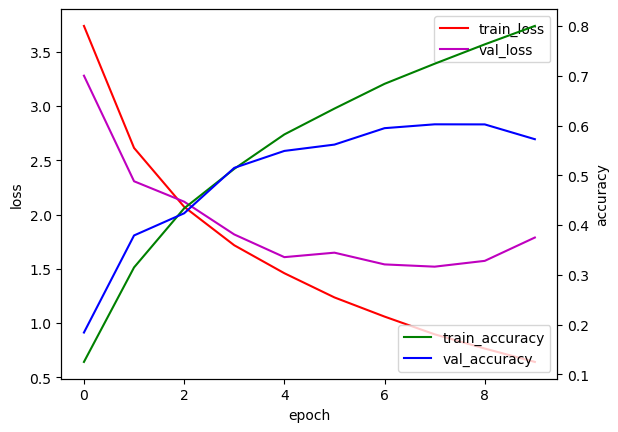

In [5]:
plot_training_progress(results_path)

#### 3.5.2.3 No Augmentation with Attention Mechanism

In [3]:
# time recording start
start_time = time.time()

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

# Define transforms for data preprocessing
transform = transforms.Compose([
    transforms.Resize((456, 456)),  # Resize input images to match EfficientNet-B5 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize input images
])

# Load the combined dataset
dataset = ImageFolder('./MO_106/', transform=transform)

# Split the dataset into training and validation sets
train_ratio = 0.8  # 80% for training, 20% for validation
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Training loop
num_epochs = 10
batch_size = 10
lr = 0.001

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize the EfficientNet-B5 model
model = EfficientNet.from_pretrained('efficientnet-b5')

# Get the number of output channels from the EfficientNet model
num_channels = model._fc.in_features

# Define the attention module
class AttentionModule(nn.Module):
    def __init__(self, num_channels):
        super(AttentionModule, self).__init__()

        self.attention = nn.Sequential(
            nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_channels, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        attention = self.attention(x)
        return attention * x

# Replace the classifier with a new one for your specific number of classes
num_classes = len(dataset.classes)
model._fc = nn.Linear(num_channels, num_classes)

# Add attention module to the EfficientNet model
attention_module = AttentionModule(num_channels)
model.attention = attention_module

# Move the model to the device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# initialise ndarray to store the loss and accuracy in each epoch (on the training data)
train_loss = np.zeros(num_epochs)
train_accuracy = np.zeros(num_epochs)
val_loss = np.zeros(num_epochs)
val_accuracy = np.zeros(num_epochs)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    # # Calculate average epoch loss and accuracy
    # epoch_loss = running_loss / len(train_dataset)
    # epoch_accuracy = correct_predictions / total_predictions

    # # Print training statistics
    # print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}')

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss_epoch = 0.0
    correct_predictions_val = 0
    total_predictions_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_epoch += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            correct_predictions_val += (predicted == labels).sum().item()
            total_predictions_val += labels.size(0)

    # Calculate average epoch loss and accuracy
    train_loss[epoch] = running_loss / len(train_dataset)
    train_accuracy[epoch] = correct_predictions / total_predictions
    val_loss[epoch] = val_loss_epoch / len(val_dataset)
    val_accuracy[epoch] = correct_predictions_val / total_predictions_val

    # Print training and validation statistics
    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss[epoch]:.4f}, Train Accuracy: {train_accuracy[epoch]:.4f}, Val Loss: {val_loss[epoch]:.4f}, Val Accuracy: {val_accuracy[epoch]:.4f}')

end_time = time.time()
total_time = end_time - start_time
print(f"Training took {total_time:.2f} seconds.")

model_metrics = {
    "model_state_dict": model.state_dict(),
    "train_loss": train_loss,
    "train_accuracy": train_accuracy,
    "val_loss": val_loss,
    "val_accuracy": val_accuracy,
    'total_time': total_time
}

# Save the model parameters and metrics to a file
ResultPath = "./results/"
results_path = ResultPath + f"efficientnetb5_attention_epoch{num_epochs}_lr{lr}_bs{batch_size}.pt"

torch.save(model_metrics, results_path)


Loaded pretrained weights for efficientnet-b5
Epoch 1/10: Train Loss: 2.3990, Train Accuracy: 0.3827, Val Loss: 1.7823, Val Accuracy: 0.5409
Epoch 2/10: Train Loss: 1.3895, Train Accuracy: 0.6084, Val Loss: 1.4549, Val Accuracy: 0.6285
Epoch 3/10: Train Loss: 1.0226, Train Accuracy: 0.7026, Val Loss: 4.1762, Val Accuracy: 0.6603
Epoch 4/10: Train Loss: 0.8473, Train Accuracy: 0.7476, Val Loss: 1.1902, Val Accuracy: 0.6847
Epoch 5/10: Train Loss: 0.6844, Train Accuracy: 0.7930, Val Loss: 1.1772, Val Accuracy: 0.7043
Epoch 6/10: Train Loss: 0.5861, Train Accuracy: 0.8219, Val Loss: 1.0956, Val Accuracy: 0.7304
Epoch 7/10: Train Loss: 0.4896, Train Accuracy: 0.8468, Val Loss: 1.1877, Val Accuracy: 0.7175
Epoch 8/10: Train Loss: 0.4399, Train Accuracy: 0.8645, Val Loss: 1.1164, Val Accuracy: 0.7424
Epoch 9/10: Train Loss: 0.3943, Train Accuracy: 0.8765, Val Loss: 1.0680, Val Accuracy: 0.7433
Epoch 10/10: Train Loss: 0.3491, Train Accuracy: 0.8905, Val Loss: 1.2587, Val Accuracy: 0.7199
Tra

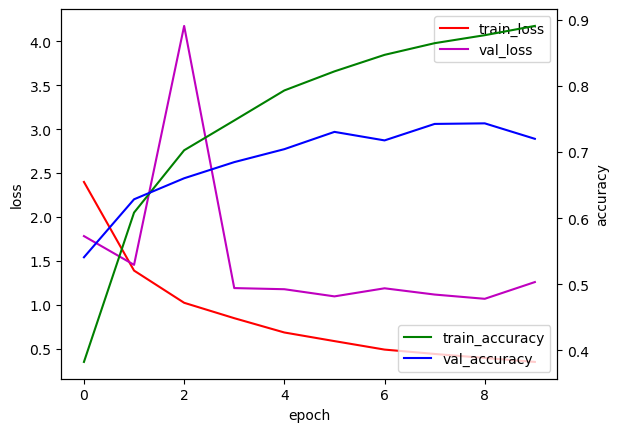

In [4]:
# plot training progress
plot_training_progress(results_path)